In [1]:
# Load packages
import sys
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb

In [2]:
path = '../covid19-global-forecasting-week-1/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'submission.csv')

In [3]:
train['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cruise Ship', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'French Guiana', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guadeloupe',
       'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'Holy See',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia

In [4]:
def country_new_cases(country_string):
    c_mask = train['Country/Region'] == country_string
    gr_data = train[c_mask].groupby('Date')['ConfirmedCases'].sum()
    gr_data.plot(marker='x')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(country_string)
        
    t = gr_data[1:]
    t_minus_1 = gr_data[:-1]
    fd_vals = (t.values - t_minus_1.values)
    fd_df = pd.DataFrame(data={'New cases per day':fd_vals}, index=t.index)
    fd_df.plot(marker='x')
    plt.xticks(rotation=45)

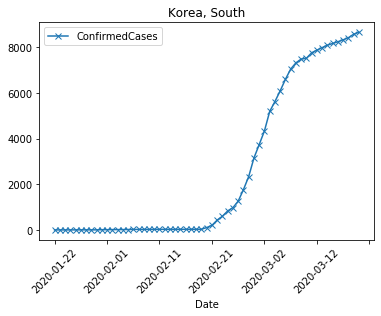

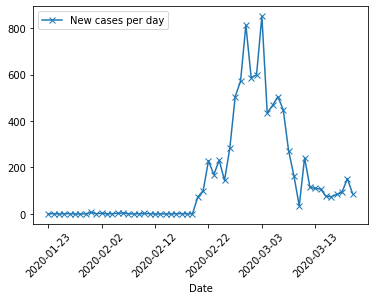

In [5]:
country_new_cases('Korea, South')

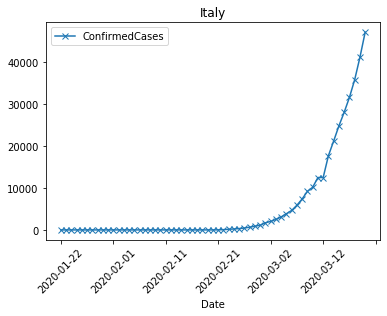

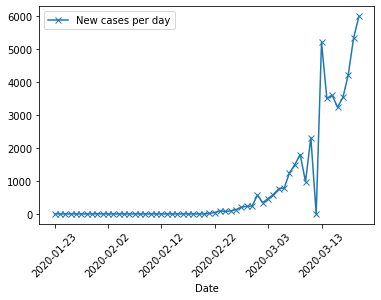

In [6]:
country_new_cases('Italy')

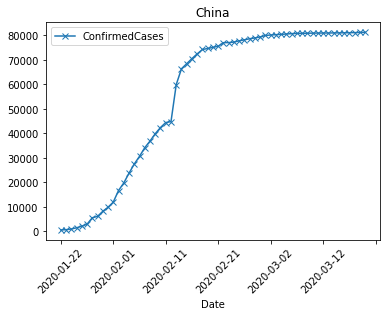

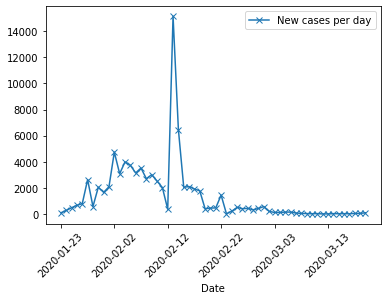

In [7]:
country_new_cases('China')

I think doing something about this anomalous day is going to be important for model training.

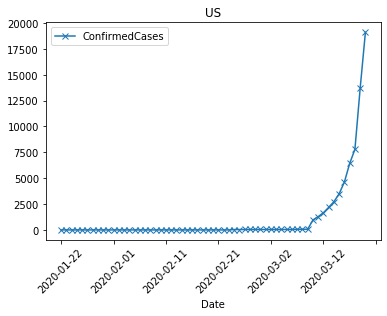

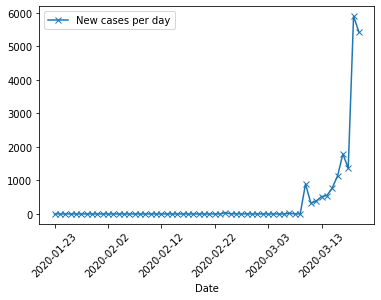

In [8]:
country_new_cases('US')

It seems like either prediction number of new cases per day, or cumulative, is the way to go. I wonder though if a good next step is to normalize this on population of the country? That way, potentially we have more apples-to-apples comparisons between countries.

# Appendix with crazy ideas

Target variable: a real number.

This is put through an exponential transformation, to make it strictly positive. The result of this is multiplied by the previous days' number of new confirmed cases. If it's > 1, the # of new cases goes up in that country/state. If it's < 1, it goes down. It could potentially go to zero.

Ideally then I'd be able to calculate the cumulative number in the cost function for XGBoost, and use it with the formula given for the competition.

I'd like to somehow include population carrying capacity in here. For example, a feature could be a standard normal transformation of what % of the population has it. The increase would theoretically be quickest when 1/2 the population, cumulatively, has had it.

While I was thinking about having an engineered "interconnectedness" variable, I wonder if I could just let XGBoost figure this out on its own. The history of new cases in other countries (maybe I should just have this at the continent/very large country scale) can affect the number of new cases.

Then, I think this is really crucial, is to include features around preventative measures taken. These need to somehow be comparable across countries/states and would potentially be difficult to make. What other country/state level variables? Population density seems important.

---

A stretch goal here might be to have some kind of estimation of how much of the population truly has it, based on the % tested and the positive rate of the tests. Presumably it's much more than the number of confirmed cases. This would be reality, which would be the best process to model: https://ourworldindata.org/covid-testing . The problem here being I'd need this over time... which in fact is available, apparently, in this data set (although it's called "Year", I think they mean "Day"), although a lot are missing. What I might be able to estimate here, is some kind of percentage of tests that are positive by country (may just have one data point in time per country for this, but could assume the proportaion of number of tests to the number of cases is constant. That would be illuminating just to look at. Are they very different across countries? This may serve as a "scaling factor" for how many cases there truly are.

# The exponential function

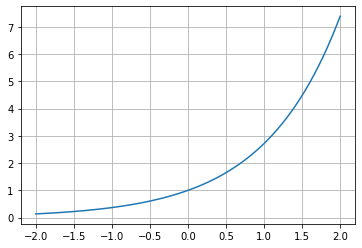

In [9]:
X = np.linspace(-2,2,201)
y = np.exp(X)
plt.plot(X,y)
plt.grid()

Now I realize, that my idea above relies on having a custom objective function in XGBoost. However, XGBoost requires custom objectives in the form of 1st and 2nd derivatives of the objective, which seems way too complicated for my idea above.

If we are predicting the number of new cases, what will the objective function be?

First the dataset needs to be defined in terms of the transformed variable. A first difference gives the number of new cases. Then, a division by the previous days' number of new cases, for that country and state, gives the multiplier $m$. Potentially, then, the logarithm could be taken, and the time series could be used for direct prediction with XGBoost regressor.

However I had explore this a bit and the data for such transformed targets seems kind of noisy.

---

I wonder what time series of various variable transformations would look like for a few example countries?

In [10]:
china_mask = train['Country/Region'] == 'China'
gr_data = train[china_mask].groupby('Date')['Fatalities'].sum()
t = gr_data[1:]
t_minus_1 = gr_data[:-1]
fd_vals = (t.values - t_minus_1.values)

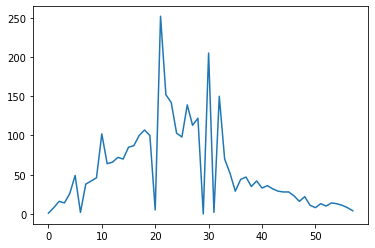

In [11]:
plt.plot(fd_vals)

/Users/Steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


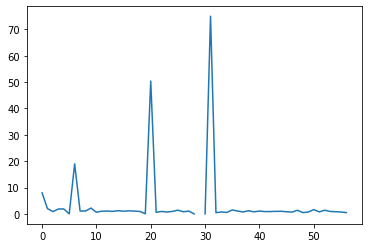

In [12]:
t2 = fd_vals[1:]
t2_minus_1 = fd_vals[:-1]
m = np.divide(t2, t2_minus_1)
plt.plot(m)

/Users/Steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


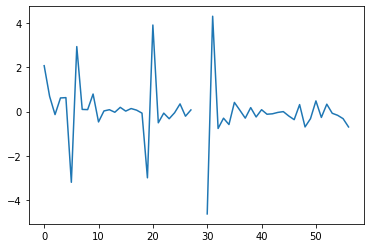

In [13]:
plt.plot(np.log(m))

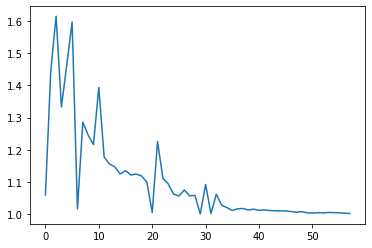

In [14]:
m0 = np.divide(t.values, t_minus_1.values)
plt.plot(m0)

In [15]:
def country_ratio_plots(country_string):
    c_mask = train['Country/Region'] == country_string
    gr_data = train[c_mask].groupby('Date')['Fatalities'].sum()
    
    gr_data.plot()
    
    #Add a small constant to avoid zero data
    gr_data[gr_data == 0] = gr_data[gr_data == 0] + 1
    
    t = gr_data[1:]
    t_minus_1 = gr_data[:-1]
    fd_vals = (t.values - t_minus_1.values)
    
    fig, axs = plt.subplots(1,3)
    
    axs[0].plot(fd_vals)
    
    m0 = np.divide(t.values, t_minus_1.values)
    axs[1].plot(m0)
    
    t2 = fd_vals[1:]
    t2_minus_1 = fd_vals[:-1]
    m1 = np.divide(t2, t2_minus_1)
    axs[2].plot(m1)
    plt.tight_layout()

/Users/Steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/Steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


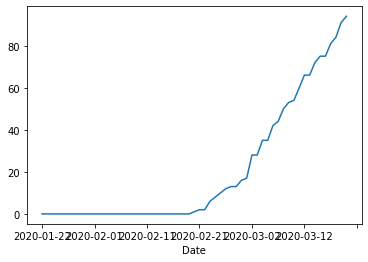

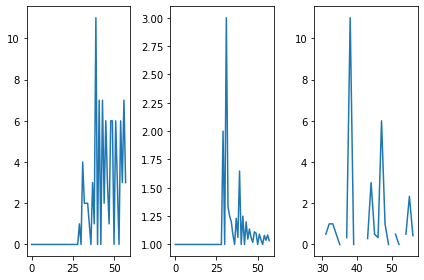

In [16]:
country_ratio_plots('Korea, South')

In [17]:
def country_ratio_plots_cases(country_string):
    c_mask = train['Country/Region'] == country_string
    gr_data = train[c_mask].groupby('Date')['ConfirmedCases'].sum()
    
    gr_data.plot()
    
    #Add a small constant to avoid zero data
    gr_data[gr_data == 0] = gr_data[gr_data == 0] + 1
    
    t = gr_data[1:]
    t_minus_1 = gr_data[:-1]
    fd_vals = (t.values - t_minus_1.values)
    
    fig, axs = plt.subplots(1,3)
    
    axs[0].plot(fd_vals)
    
    m0 = np.divide(t.values, t_minus_1.values)
    axs[1].plot(m0)
    
    t2 = fd_vals[1:]
    t2_minus_1 = fd_vals[:-1]
    m1 = np.divide(t2, t2_minus_1)
    axs[2].plot(m1)
    plt.tight_layout()

/Users/Steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/Steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


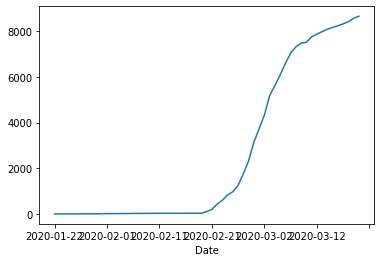

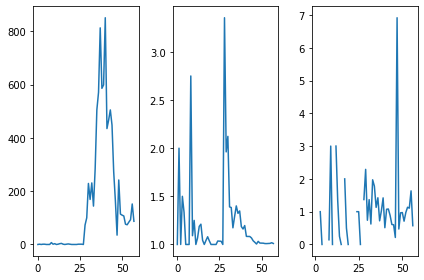

In [18]:
country_ratio_plots_cases('Korea, South')

These look noisy for China and S. Korea. I think we may actually just want to stick with the supplied target, or the "new cases per day".

Look at these for a few other countries.